# Finite Markov Decision Processes

Finite MDP.
Difference to previous chapter: State $q_*(a) \rightarrow q_*(a,s)$

## Environment

Probability of state $s'$ and reward $r$ prior state $s$ and action $a$:

\begin{align}
p(s',r|s,a) = \operatorname{Pr}\left\{ S_t=s', R_t=r \;|\; S_{t-1}, A_{t-1}=a\right\}
\end{align}

The *state-transition probabilities*

\begin{align}
p(s'|s,a) = \sum_r p(s',r|s,a)
\end{align}

### Example: Recycling Robot

**States:** Battery load: *high* and *low*
**Actions:** *search*, *wait* and *recharge*

#### Reward and probability table

 $s$ | $a$ | $s'$ | $p(s';s,a)$ | $r(s,a,s')$
 --- | --- | --- | --- | ---
 high| search | high | $\alpha$ | $r_\text{search}$
 high| search | low  | $1-\alpha$ | $r_\text{search}$
 low | search | high | $1-\beta$ | $-3$
 low | search | low  | $\beta$  | $r_\text{search}$
 high| wait   | high | $1$      | $r_\text{wait}$
 high| wait   | low  | $0$      | -
 low | wait   | high | $0$      | -
 low | wait   | low  | $1$      | $r_\text{wait}$
 low | recharge | high | $1$    | $0$
 low | recharge | low  | $0$    | -


In [1]:
!pip install -r ../requirements.txt

In [2]:
import dm_env
from dm_env import specs
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Sequence, Any


@dataclass(frozen=True, eq=True)
class StateAction:
    state: str
    action: str


@dataclass(frozen=True, eq=True)
class NextStates:
    state_a: str
    state_b: str
    reward_a: float
    reward_b: float
    probability_a: float

    def next(self, rng: np.random.RandomState) -> Tuple[str, float]:
        if rng.random() <= self.probability_a:
            return (self.state_a, self.reward_a)
        else:
            return (self.state_b, self.reward_b)


class RecyclingRobot(dm_env.Environment):
    def __init__(self, alpha: float = 0.9, beta: float = 0.95, r_search: float = 1.0, r_wait: float = 0., seed: int = 1) -> None:
        self._seed = seed
        self._reset()

        self._actions = ['search', 'wait', 'recharge']
        self._transitions = {
            StateAction('high', 'search'): NextStates('high', 'low', r_search, r_search, alpha),
            StateAction('low', 'search'): NextStates('high', 'low', -3, r_search, 1. - beta),
            StateAction('high', 'wait'): NextStates('high', 'low', r_wait, 0., 1.),
            StateAction('low', 'wait'): NextStates('high', 'low', 0, r_wait, 0.),
            StateAction('low', 'recharge'): NextStates('high', 'low', 0., 0., 1.),
        }

    def reset(self) -> dm_env.TimeStep:
        self._reset()
        return dm_env.restart(reward=0., observation=np.asarray([0]))

    def step(self, action) -> dm_env.TimeStep:
        action_name = self._actions[action]
        prior = StateAction(self.state, action_name)
        self.state, reward = self._transitions[prior].next(self._rng)
        observation = self._actions.index(self.state)

        # when to terminate?
        # return dm_env.termination(reward=reward, observation=observation)

        return dm_env.transition(reward=reward, observation=observation, discount=0.9)

    def observation_spec(self) -> specs.BoundedArray:
        return specs.BoundedArray(
            shape=(1,),
            dtype=np.float_,
            name="recycling-robot",
            minimum=0,
            maximum=2,
        )

    def action_spec(self) -> specs.DiscreteArray:
        return specs.DiscreteArray(dtype=int, num_values=1, name="action")

    def _reset(self):
        self._rng = np.random.RandomState(self._seed)
        self.state = 'high'

    @property
    def available_states(self) -> Sequence[Any]:
        """This function is needed when iterating over all states"""
        
        yield 'low'
        yield 'high'

    def state_index(self, state: np.array) -> int:
        return state[0]

## Returns and Episodes

Return with discount $\gamma$ is given by:

\begin{align}
G_t := \sum_{k=0}^\infty \gamma^k R_{t+t+1} = R_{t+1} + \gamma G_{t+1}
\end{align}

## Policy and Value Functions

The *value-function* under policy $\pi$

\begin{align}
v_\pi(s) :=&\; \mathbb{E}\left[G_t\;|\; S_t=s\right] \\
=&\; \sum_a \pi(a|s)\sum_{s',r} p(s',r\,|\,s,a)\left[r+\gamma v_\pi(s') \right]
\end{align}

The *action-value-function* 
\begin{align}
q_\pi(s,a) :=&\; \mathbb{E}\left[G_t\;|\; S_t=s S_t=a\right]
\end{align}



In [3]:
from typing import Sequence, Any, Dict


@dataclass(frozen=True, eq=True)
class Position:
    x: int
    y: int

    def numpy(self):
        return np.asarray([self.y, self.x])

    @staticmethod
    def from_numpy(array: np.array) -> "Position":
        assert array.shape == (2,)
        return Position(array[1], array[0])

    def __iadd__(self, other: "Position") -> "Position":
        self.x += other.x
        self.y += other.y
        return self

    def __add__(self, other: "Position") -> "Position":
        return Position(self.x + other.x, self.y + other.y)

    def is_in_rectangle(self, height: int, width: int) -> bool:
        return width > self.x >= 0 and height > self.y >= 0


@dataclass(frozen=True, eq=True)
class BeamAction(Position):
    reward: float


class GridWorld(dm_env.Environment):

    def __init__(self, width: int, height: int, beam_actions: Dict[Position, BeamAction],
                 initial: Position = None, discount: float = 0.9, seed: int = 1) -> None:
        self._seed = seed
        self._discount = discount
        self._width = width
        self._height = height
        self._beam_actions = beam_actions
        self._initial = initial or Position(0, 0)
        self._reset()

        self._actions = {
            'north': Position(0, -1),
            'south': Position(0, 1),
            'west': Position(-1, 0),
            'east': Position(1, 0)
        }

        self.action_names = sorted(list(self._actions.keys()))

    def step(self, action) -> dm_env.TimeStep:
        # reward of -1 if walking out of boundaries
        # reward of +10 when reaching a_source
        # reward of +5 when reaching b_source
        # no reward else
        delta = self._actions[self.action_names[action]]
        candidate = self.state + delta
        if candidate in self._beam_actions:
            beam = self._beam_actions[candidate]
            reward = beam.reward
            self.state = Position(beam.x, beam.y)
        elif candidate.is_in_rectangle(self._height, self._width):
            reward = 0
            self.state = candidate
        else:
            reward = -1
        return dm_env.transition(reward=reward, observation=self.state.numpy(), discount=self._discount)

    def reset(self) -> dm_env.TimeStep:
        self._reset()
        return dm_env.restart(reward=0., observation=self.state.numpy())

    def observation_spec(self) -> specs.BoundedArray:
        return specs.BoundedArray(
            shape=(2,),  # current locations
            dtype=np.int32,
            name="grid-world",
            minimum=max(self._width, self._height),
            maximum=0,
        )

    def action_spec(self) -> specs.DiscreteArray:
        return specs.DiscreteArray(dtype=int, num_values=1, name="action")

    def _reset(self):
        self._rng = np.random.RandomState(self._seed)
        self.state = self._initial

    @property
    def available_states(self) -> Sequence[Any]:
        """This function is needed when iterating over all states"""
        for x in range(self._width):
            for y in range(self._height):
                candidate = Position(x, y)
                # if candidate == self._a_source or candidate == self._b_source:
                #     continue
                yield candidate

    def state_index(self, state: np.array) -> int:
        location = Position.from_numpy(state)
        return location.x * self._width + location.y


## Optimal Policies and Optimal Value Functions

The optimal *state-value-function* is defined 

\begin{align}
v_*(s) := \max_\pi v_\pi(s)
\end{align}

The optimal *action-value-function* is defined

\begin{align}
q_*(s, a) :=& \max_\pi q_\pi(s, a) \\
=& \sum_{s',r} p(s',r\,|\, s, a) \left[r+\gamma \max_{a'}q_*(s', a') \right]
\end{align}

### Solving the Grid-World

Finding the optimal *state-value-function* leads to the optimal optimal *policy-function*

100%|██████████| 1000/1000 [00:00<00:00, 116995.93it/s]


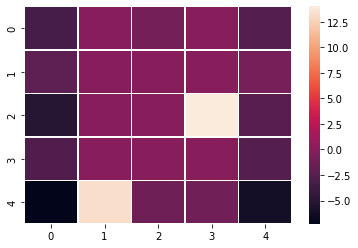

[[-3.35467178  0.         -0.90876411  0.         -2.6161441 ]
 [-2.09589488  0.          0.          0.         -0.85427771]
 [-5.11390602  0.          0.         14.00744842 -2.34259947]
 [-2.80039111  0.          0.          0.         -2.61680176]
 [-7.27663664 13.28515612 -1.35618216 -1.06345616 -6.16948784]]


In [12]:
from tqdm import tqdm
import seaborn as sns
import matplotlib.pylab as plt


def softmax(values: np.array):
    exp = np.exp(values)
    return exp / np.sum(exp)


WIDTH = 5
HEIGHT = 5

beam_actions = {
    Position(1, 0): BeamAction(1, 4, reward=10.),
    Position(3, 0): BeamAction(3, 2, reward=5.),
}

env = GridWorld(width=WIDTH, height=HEIGHT, beam_actions=beam_actions)

STEPS = 1000
GAMMA = 0.9

rng = np.random.RandomState(seed=0)
values = np.zeros((HEIGHT, WIDTH))

for _ in tqdm(range(STEPS)):
    action = rng.randint(len(env.action_names))
    step = env.step(action)
    ob = tuple(step.observation)
    values[ob] *= GAMMA
    values[ob] += step.reward


ax = sns.heatmap(values, linewidth=0.5)
plt.show()
